# Logistic Regression: cat or dog?
In this lab you will teach computer to distinguish between images of cats and dogs using Logistic Regression. 
The input dataset consists of 10,000 images manually labeled as ''cats'' and ''dogs''. The original dataset was downloaded from kaggle. 

Download the entire [folder](https://drive.google.com/file/d/1V4pAtGy7VOJQlxM3g8gyDee8h5k7VTSF/view?usp=sharing)  with images and unzip it into your local directory containing input files for this course. Then set the path below to point to this directory.

In [1]:
data_dir = "../data_set/cat_dog_data"

## 1. Building the model

### 1.1. Import all the required libraries. 
If you get an import error on `keras`, run one of the next 2 cells to install `keras` in the current Jupyter kernel, and then rerun the import cell. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from PIL import Image
from keras import preprocessing
import sys

### 1.2. Load images
First check if the path to the directory is correct:

In [3]:
import os
cwd = os.getcwd()
os.chdir(cwd)
print(os.listdir(data_dir))

['.DS_Store', 'training_set', 'test_set']


Next create two lists and fill them with the paths to the corresponding images. 

In [4]:
train_cats_files = []
train_path_cats = data_dir +"/training_set/cats/"
for path in os.listdir(train_path_cats):
    if '.jpg' in path:
        train_cats_files.append(os.path.join(train_path_cats, path))
        
train_dogs_files = []
train_path_dogs = data_dir +"/training_set/dogs/"
for path in os.listdir(train_path_dogs):
    if '.jpg' in path:
        train_dogs_files.append(os.path.join(train_path_dogs, path))
        
len(train_cats_files), len(train_dogs_files)

(4000, 4000)

Now we have the paths to each image in the training set.
We need to convert each image into a numpy array. For this we use the preprocessing module in the `keras` library. 

In [5]:
k = 200
sample_dog_file = train_dogs_files[k]
img = preprocessing.image.load_img(sample_dog_file, target_size=(64, 64))
img_array = preprocessing.image.img_to_array(img)

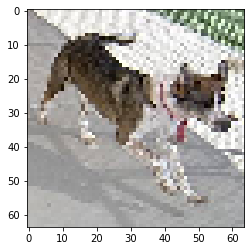

In [6]:
plt.imshow(np.uint8(img_array))

In [7]:
img_array.shape
# print(img_array)

(64, 64, 3)

Each image is represented as a $64*64$ matrix of pixels, and for each pixel we have values of Red, Green, and Blue (RGB). 

### 1.3. Images to numpy arrays
Now we create training sets for cats and for dogs and then concatenate 2 sets into a single `X_train` dataset of features.

In [8]:
# image dimensions: using 32x32 pixels just for speed
d = 64
X_train_orig = np.zeros((8000, d, d, 3), dtype='float32')
for i in range(4000):    
    path = train_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)

for i in range(4000,8000):    
    path = train_dogs_files[i-4000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)    

X_train_orig.shape

(8000, 64, 64, 3)

### 1.4. Flatten 3D image arrays
Our model requires each object to be a 1D vector of features -
we need to flatten our 3D image arrays.

After reshaping we will have,
$d*d*3$ features as a single array for each picture in the training set (8000 pics),

In [10]:
X_train = X_train_orig / 255.0
print(X_train[0])
X_train.shape

[[[0.13333334 0.09411765 0.05882353]
  [0.13333334 0.09411765 0.05882353]
  [0.12941177 0.10196079 0.0627451 ]
  ...
  [0.4        0.25490198 0.15294118]
  [0.41568628 0.23921569 0.14901961]
  [0.39607844 0.2784314  0.16862746]]

 [[0.14509805 0.10588235 0.07058824]
  [0.14117648 0.10196079 0.06666667]
  [0.14509805 0.11764706 0.07843138]
  ...
  [0.40392157 0.28235295 0.17254902]
  [0.43137255 0.28627452 0.18431373]
  [0.40392157 0.3137255  0.19215687]]

 [[0.14117648 0.10196079 0.06666667]
  [0.15294118 0.11372549 0.07843138]
  [0.15294118 0.11372549 0.07843138]
  ...
  [0.42352942 0.30588236 0.21176471]
  [0.41960785 0.2784314  0.19215687]
  [0.39607844 0.3137255  0.20784314]]

 ...

 [[0.2509804  0.1882353  0.12941177]
  [0.28235295 0.21960784 0.16078432]
  [0.25882354 0.19607843 0.13725491]
  ...
  [0.00392157 0.00784314 0.        ]
  [0.1882353  0.12156863 0.05882353]
  [0.2784314  0.21960784 0.12941177]]

 [[0.22745098 0.1882353  0.14901961]
  [0.24313726 0.20392157 0.16470589]


(8000, 64, 64, 3)

### 1.5. Create class labels
Now we need to create the corresponding class label vectors. We will mark the cats as class 1, and the dogs as class 0 (not cats).

In [11]:
Y_train_orig = np.ones((4000,)) # 1 - 4000 are cat pictures so our label is 1
Y_train_orig = np.concatenate((Y_train_orig, np.zeros((4000,)))) # 4000 - 8000 are dog pictures so our label is 0
Y_train = Y_train_orig.reshape(-1)
print("At position 3 should be a cat:", Y_train[3])
print("At position 4002 should be a dog:", Y_train[4002])

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 2)

Y_train.shape

At position 3 should be a cat: 1.0
At position 4002 should be a dog: 0.0


(8000, 2)

### 1.6. Build the model
We are using the `LogisticRegression` class from `sklearn` package.
<ul>
<li>The <code>random_state</code> parameter tells to shuffle the samples, so the classifier does not see all the cats first, and then the dogs. Specifying  the `random_state` value ensures that the algorithm starts from the same random seed and produces reproducible results.</li> 
<li>The <code>max_iter</code> parameter tells algorithm to stop even if it did not reach the thrreshold for convergence yet.</li>
    <li>In the <code>solver</code> parameter you can specify the algorithm which you want to use.</li>
</ul>

You can read more about the parameters of  `LogisticRegression` model [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

The score of the logistic regression classifier is simply a percentage of correctly predicted data points. This measure is called the **accuracy** of the model.

In [ ]:
acc_train = logreg.score(X_train, Y_train)
print("train accuracy: {} ".format(acc_train))

## 2. Lab Task 1: Model evaluation  \[60%\]
Obviously, we are much more interested to see how our model performs on the test data. To create a test set, repeat steps 1.2-1.5 for the test_set folder.

### 2.1. Load images

In [12]:
test_cats_files = []
test_path_cats = data_dir +"/test_set/cats/"
for path in os.listdir(test_path_cats):
    if ".jpg" in path:
        test_cats_files.append(os.path.join(test_path_cats,path))

test_dogs_files = []
test_path_dogs = data_dir +"/test_set/dogs/"
for path in os.listdir(test_path_dogs):
    if '.jpg' in path:
        test_dogs_files.append(os.path.join(test_path_dogs, path))

len(test_cats_files), len(test_dogs_files)

(1000, 1000)

### 2.2. Images to numpy arrays

In [13]:
X_test_orig = np.zeros((2000, d, d, 3), dtype='float32')

for i in range(1000):
    img = preprocessing.image.load_img(test_cats_files[i], target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)
    
for i in range(1000, 2000):
    img = preprocessing.image.load_img(test_dogs_files[i-1000], target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)
    
X_test_orig.shape

(2000, 64, 64, 3)

### 2.3. Flatten 3D image arrays

In [15]:
X_test = X_test_orig / 255.0
print(X_test[0])
X_test.shape

[[[0.09803922 0.03921569 0.6392157 ]
  [0.23529412 0.20784314 0.64705884]
  [0.18431373 0.22352941 0.5647059 ]
  ...
  [0.25490198 0.21176471 0.5803922 ]
  [0.2627451  0.20784314 0.5921569 ]
  [0.2        0.14901961 0.59607846]]

 [[0.23137255 0.21176471 0.6117647 ]
  [0.9843137  0.9882353  0.95686275]
  [0.9529412  1.         1.        ]
  ...
  [0.99215686 0.972549   0.9882353 ]
  [0.96862745 0.972549   0.9490196 ]
  [0.8        0.7372549  0.63529414]]

 [[0.27450982 0.1764706  0.6862745 ]
  [0.9411765  0.9372549  1.        ]
  [0.6666667  0.7764706  0.7176471 ]
  ...
  [0.8901961  0.90588236 0.9019608 ]
  [0.89411765 0.9490196  0.8901961 ]
  [0.8235294  0.72156864 0.73333335]]

 ...

 [[0.28235295 0.19607843 0.5803922 ]
  [0.9254902  0.8784314  0.8156863 ]
  [0.45490196 0.22745098 0.14117648]
  ...
  [0.67058825 0.25882354 0.24313726]
  [0.65882355 0.2627451  0.18431373]
  [0.7176471  0.76862746 0.5882353 ]]

 [[0.23921569 0.25882354 0.50980395]
  [0.96862745 1.         0.8980392 ]


(2000, 64, 64, 3)

### 2.4. Create class labels

In [16]:
Y_test_orig = np.ones((1000,))
Y_test_orig = np.concatenate((Y_test_orig, np.zeros((1000,)))) 
Y_test = Y_test_orig.reshape(-1)
Y_test = to_categorical(Y_test, num_classes = 2)

Y_test.shape

(2000, 2)

In [54]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [55]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [56]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [57]:
# Fit the model
epochs = 10
batch_size = 250

history = model.fit(X_train,Y_train, epochs = epochs, validation_data = (X_test,Y_test), steps_per_epoch=X_train.shape[0] // batch_size)


Epoch 1/10
32/32 [==============================] - 11s 336ms/step - loss: 0.7248 - accuracy: 0.5145 - val_loss: 0.6916 - val_accuracy: 0.5070
Epoch 2/10
32/32 [==============================] - 10s 306ms/step - loss: 0.6894 - accuracy: 0.5379 - val_loss: 0.6892 - val_accuracy: 0.5115
Epoch 3/10
32/32 [==============================] - 10s 311ms/step - loss: 0.6791 - accuracy: 0.5714 - val_loss: 0.6837 - val_accuracy: 0.5180
Epoch 4/10
32/32 [==============================] - 10s 312ms/step - loss: 0.6623 - accuracy: 0.6028 - val_loss: 0.6621 - val_accuracy: 0.5815
Epoch 5/10
32/32 [==============================] - 10s 318ms/step - loss: 0.6384 - accuracy: 0.6380 - val_loss: 0.6294 - val_accuracy: 0.6425
Epoch 6/10
32/32 [==============================] - 10s 318ms/step - loss: 0.6213 - accuracy: 0.6535 - val_loss: 0.6199 - val_accuracy: 0.6610
Epoch 7/10
32/32 [==============================] - 11s 330ms/step - loss: 0.6030 - accuracy: 0.6714 - val_loss: 0.6088 - val_accuracy: 0.6675

### 2.5. Accuracy for the test set

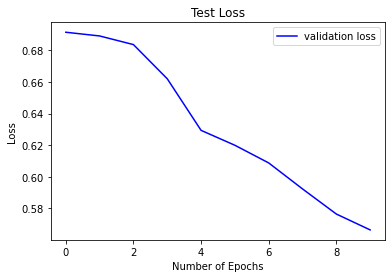

In [58]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

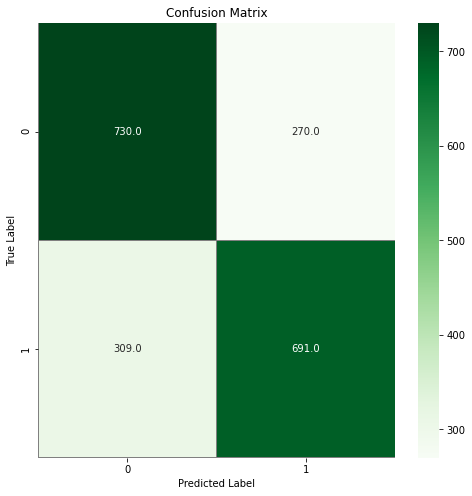

In [59]:
# compute the confusion matrix
import seaborn as sns

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

[[0.432491   0.567509  ]
 [0.40028515 0.5997148 ]]


<Figure size 432x288 with 0 Axes>

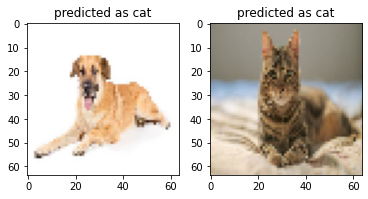

In [60]:
# predict random image of cat and dog
d = 64

test_dir = "./"
test_path_files = []
for path in os.listdir(test_dir):
    if ".jpg" in path:
        test_path_files.append(os.path.join(test_dir,path))

img_arr = np.zeros((2, d, d, 3), dtype='float32')
for i in range(2):
    img = preprocessing.image.load_img(test_path_files[i], target_size=(d, d))
    img_arr[i] = preprocessing.image.img_to_array(img)

X_new = img_arr / 255
Y_new = model.predict(X_new)
print(Y_new)
Y_new_classes = np.argmax(Y_new,axis = 1) 

display = ['dog','cat']
%matplotlib inline

plt.figure()
f, axarr = plt.subplots(1,2) 

for i in range(2):
    axarr[i].imshow(np.uint8(img_arr[i]))
    axarr[i].set_title("predicted as "+display[int(Y_new_classes[i])])